In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr, ranksums
import seaborn as sns
import os
from scipy.cluster import hierarchy as sch

sns.set_style('white')

def positioning(x):
    return x[-1]

def count_to_cpm(count_array):
    count_array = np.true_divide(count_array,count_array.sum()) * 1e6 
    return count_array

def get_end(x):
    if 'head' in x:
        return "5'"
    elif 'tail' in x:
        return "3'"

def make_column_name(colnames):
    col_d = pd.DataFrame({'nucleotide':colnames.str.slice(-1),
                 'position':colnames.str.slice(4,5),
                 'end':colnames.map(get_end)}) \
        .assign(offset = lambda d: np.where(d.end=="5'",-1, 3)) \
        .assign(adjusted_position = lambda d: np.abs(d.position.astype(int) - d.offset))\
        .assign(colnames = colnames)
    #print col_d
    return col_d.end + '-position:'+col_d.adjusted_position.astype(str) +':'+ col_d.nucleotide
    
def preprocess_dataframe(df):
    nucleotides = df.columns[df.columns.str.contains('head|tail')]
    dummies = pd.get_dummies(df[nucleotides])
    dummies.columns = make_column_name(dummies.columns)
    df = pd.concat([df,dummies],axis=1) \
        .drop(nucleotides, axis=1) 
    return df

In [3]:
df = pd.read_table('../test/test_train_set.tsv')\
    .assign(expected_cpm = lambda d: count_to_cpm(d['expected_count']))\
    .assign(cpm = lambda d: count_to_cpm(d['experimental_count']))\
    .assign(log_cpm = lambda d: np.log2(d.cpm+1) - np.log2(d.expected_cpm+1))\
    .pipe(preprocess_dataframe) \
    .drop(['experimental_count','cpm'], axis=1)
df.head()

,seq_id,expected_count,expected_cpm,log_cpm,5'-position:1:A,5'-position:1:C,5'-position:1:G,5'-position:1:T,5'-position:2:A,5'-position:2:C,...,3'-position:3:G,3'-position:3:T,3'-position:2:A,3'-position:2:C,3'-position:2:G,3'-position:2:T,3'-position:1:A,3'-position:1:C,3'-position:1:G,3'-position:1:T
0,EBV-1-1,10000,1040.582726,-7.270792,0,0,0,1,1,0,...,1,0,0,0,0,1,0,0,0,1
1,EBV-1-2,10000,1040.582726,1.503831,0,0,0,1,1,0,...,0,1,0,0,1,0,1,0,0,0
2,EBV-1-2-star,10000,1040.582726,-2.773024,1,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
3,EBV-1-3,10000,1040.582726,-2.085227,0,0,0,1,1,0,...,0,0,0,1,0,0,1,0,0,0
4,EBV-1-3P,10000,1040.582726,-2.282994,0,0,0,1,1,0,...,1,0,0,0,0,1,0,1,0,0


In [4]:
X = df.drop(['seq_id','log_cpm','expected_count','expected_cpm'], axis=1)
X.columns

Index([u'5'-position:1:A', u'5'-position:1:C', u'5'-position:1:G',
       u'5'-position:1:T', u'5'-position:2:A', u'5'-position:2:C',
       u'5'-position:2:G', u'5'-position:2:T', u'5'-position:3:A',
       u'5'-position:3:C', u'5'-position:3:G', u'5'-position:3:T',
       u'3'-position:3:A', u'3'-position:3:C', u'3'-position:3:G',
       u'3'-position:3:T', u'3'-position:2:A', u'3'-position:2:C',
       u'3'-position:2:G', u'3'-position:2:T', u'3'-position:1:A',
       u'3'-position:1:C', u'3'-position:1:G', u'3'-position:1:T'],
      dtype='object')

plotted  /stor/home/cdw2854/miRNA_seq/tgirt_smRNA_correction/notebook/expression_prediction.pdf


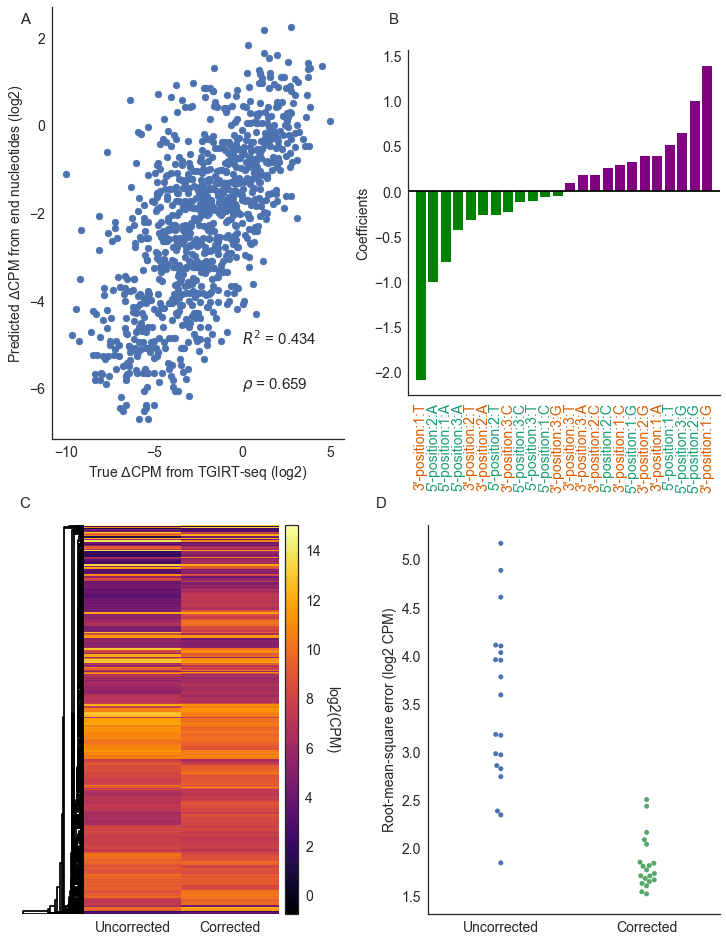

In [12]:
def train_lm(d, ax):
    X = d.drop(['seq_id','log_cpm','expected_count','expected_cpm'], axis=1)
    Y = d['log_cpm'].values
    lm = Ridge()
    lm.fit( X, Y)
    pred_Y = lm.predict(X)
    rsqrd = explained_variance_score(Y, pred_Y)
    rho, pval = pearsonr(pred_Y, Y)
    ax.scatter(Y, pred_Y)
    ax.text(0,-5, '$R^2$ = %.3f' %(rsqrd), fontsize=15)
    ax.text(0,-6, r'$\rho$ = %.3f' %rho, fontsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(r'True $\Delta$CPM from TGIRT-seq (log2)')
    ax.set_ylabel(r'Predicted $\Delta$CPM from end nucleotides (log2)')
    sns.despine()
    return lm, X, Y

#.assign(side = lambda d: d.X.str.replace('-position:[0-9]-[ACTG]$','')) \
#            .assign(X = lambda d: d.X.str.replace('-[ACTG]$','')) \
def coefficient_plot(d, lm, ax):
    X_factor = d.drop(['log_cpm','seq_id','expected_count','expected_cpm'], axis=1).columns
    coefficient = lm.coef_
    colors = sns.color_palette('Dark2',10)
    d = pd.DataFrame({'X': X_factor, 'coef':coefficient})  \
        .assign(side = lambda d: d.X.str.replace('','')) \
        .assign(color = lambda d: map(lambda x: colors[0] if "5'" in x else colors[1], d.side)) \
        .sort_values('coef')  \
        .assign(bar_color = lambda d: map(lambda x: 'green' if x < 0 else 'purple', d.coef))
    ax.bar(np.arange(len(d.coef)),
            d.coef,
            color = d.bar_color)
    ax.xaxis.set_ticks(np.arange(len(d.coef)))
    x = ax.set_xticklabels(d.X,rotation=90)
    for xt, col in zip(ax.get_xticklabels(), d.color):
        xt.set_color(col)
    ax.legend(title =' ')
    ax.set_ylabel('Coefficients')
    #ax.set_title('Coefficients for positional bases')
    ax.set_xlabel(' ')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.hlines(xmin=-4, xmax=len(d.coef), y = 0)
    ax.set_xlim(-1, len(d.coef))

def get_sim(df):
    sim = poisson.rvs(10000, range(df.shape[0]))
    sim = np.log2(count_to_cpm(sim)+1) - df['expected_count']
    return sim

def cross_validation(X_train, X_test, Y_train, Y_test, i):
    lm = Ridge()
    lm.fit(X_train, Y_train)

    err = X_test * lm.coef_
    err = err.sum(axis=1)
    error_df = pd.DataFrame({'Corrected':err, 
                             'Uncorrected': Y_test})\
        .pipe(pd.melt, 
              var_name = 'correction', 
              value_name = 'error') \
        .groupby('correction', as_index=False) \
        .agg({'error': lambda x: np.sqrt(x.pow(2).mean())}) 
    return error_df

def plot_error(ax, X, Y, df):
    X = df.drop(['seq_id','log_cpm','expected_count','expected_cpm'], axis=1).values
    Y = df['log_cpm'].values
    kf = KFold(n_splits=20, random_state=0)
    dfs = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index]
        df = cross_validation(X_train, X_test, Y_train, Y_test, i)
        dfs.append(df)
    error_df = pd.concat(dfs)
    sns.swarmplot(data=error_df, x = 'correction', 
                y = 'error', order=['Uncorrected','Corrected'])
    ax.set_xlabel(' ')
    ax.set_ylabel('Root-mean-square error (log2 CPM)')
    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False) 
    return error_df

def remove_grid(ax):
    for o in ['top','bottom','left','right']:
        ax.spines[o].set_visible(False) 

def make_cluster(d, ax):
    linkage_color = ['black','darkcyan','darkseagreen','darkgoldenrod']
    sch.set_link_color_palette(linkage_color)
    z = sch.linkage(compare_df)
    l = sch.dendrogram(z, orientation='left',
                      color_threshold=100,
                      no_labels=True)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    remove_grid(ax)
    return l

def plot_heat(compare_df, cl, ax, cax):
    plot_df = compare_df.iloc[cl['leaves'],[1,0]] + np.log2(1040.5)
    hm = ax.imshow(plot_df, cmap='inferno',aspect='auto')
    ax.xaxis.set_ticks(range(0,2))
    ax.set_xticklabels(plot_df.columns)
    ax.yaxis.set_visible(False)
    cb = plt.colorbar(hm, cax=cax)
    cb.set_label('log2(CPM)',rotation=270,labelpad=18)
    remove_grid(ax)
    remove_grid(cax)

plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.rc('axes',labelsize=14)
fig = plt.figure(figsize=(9,12))
ax = fig.add_axes([0,0.55,0.45,0.5])
ax2 = fig.add_axes([0.55,0.6,0.48,0.4])
lm, X, Y = train_lm(df,ax)
coefficient_plot(df, lm, ax2)


#plot heatmap and error
compare_df = pd.DataFrame({'Corrected':Y - np.sum(lm.coef_ * X, axis=1),
                           'Uncorrected':df.log_cpm})
d_ax = fig.add_axes([-0.05,0,0.1,0.45])
cl = make_cluster(compare_df, d_ax)
map_ax = fig.add_axes([0.05,0,0.3,0.45])
cbar_ax = fig.add_axes([0.36,0,0.02,0.45])
plot_heat(compare_df, cl, map_ax, cbar_ax)

ax3 = fig.add_axes([0.58,0,0.45,0.45])
error_df = plot_error(ax3, X, Y, df)

#fig.tight_layout()
fig.text(-0.05,1.03,'A',size=15)
fig.text(0.52,1.03,'B',size=15)
fig.text(-0.05, 0.47,'C',size=15)
fig.text(0.5, 0.47,'D',size=15)
figurename = os.getcwd() + '/expression_prediction.pdf'
fig.savefig(figurename, bbox_inches='tight', transparent=True)
print 'plotted ', figurename 